<a href="https://www.kaggle.com/code/daiqing2009/ocr-performance-analysis-on-license-plates?scriptVersionId=172918748" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/daiqing2009/ocr-performance-analysis-on-license-plates?scriptVersionId=172543186" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# OCR Performance Analysis on LICENSE PLATES
This notebook get hint of https://www.kaggle.com/code/aslanahmedov/automatic-number-plate-recognition, which utilized almost all the datasets in kaggle for license plate localization using YOLO. Similarly, we analyzed as many as datasets we can find in kaggle for license plate OCR:
* different scales of data(i.e. license plate images)
* different (combination of) hardware


# License plate images Preparation



### Dataset Analysis

| Name | Number of picture(approximate) | Need Crop | Crop Method | Remark|
|--- | --- | --- | --- | --- |
|number-plate-detection| 250 | Y | coordinates in XML | high-resolution pic |
|car-plate - detection | 500 | Y | coordinates in XML | medium-resolution pic  |
|indian-vehicle-dataset|1,000 | Y | coordinates in XML | low-medium resolution pic, license plate no. in XML|
| stanford-cars-dataset|20,000 | Y | annotation in mat | details in mat file unknown |
| synthetic-turkish-license-plates | 100,000 | N | N/A | synthtic crated, license plate no. as file name |
| us-license-plates | 4,000 | N | N/A | high-resulution front-view license plates with states name/symbol |
| us-license-plates | 20,000 | N | N/A | low-medium resulution front-view license plates with states name/symbol |

Besides, there's a dataset called **license-plate-digits-classification-dataset** so enable us to train own number recognition NN if needed. Since threre're plenty of **front-view license plates pictures with no need to crop** , it is  reasonable to work on those before turn to those pictures needing crop. 

## Baseline TESSERACT OCR

Optical character recognition (OCR) software that is used to extract text from the image. Tesseract OCR have a python API and it is open source. Firstly, we will do installation of it. It pretty simple and depend on you OS. You can find manual and files to download for installation [here](https://guides.library.illinois.edu/c.php?g=347520&p=4121425).

### LIMITATIONS OF PYTESSERACT
Tesseract works best when there is a clean segmentation of the foreground text from the background. 

In practice, it can be **extremely challenging to guarantee these types of setups**. There are a variety of reasons you might not get good quality output from Tesseract like if the image has noise on the background. The better the image quality (size, contrast, lightning) the better the recognition result. It requires a bit of preprocessing to improve the OCR results, images need to be scaled appropriately, have as much image contrast as possible, and the text must be horizontally aligned. 

In [17]:
%%capture
!pip install pytesseract
!pip install opencv-python
!pip install matplotlib

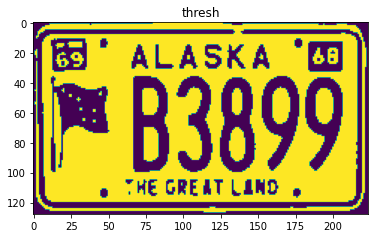

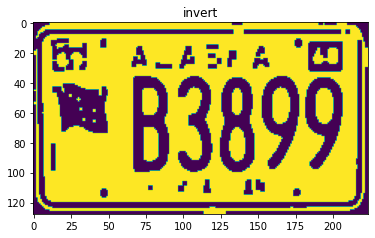

In [18]:
import pytesseract
import cv2
from matplotlib import pyplot as plt

path = "/kaggle/input/us-license-plates-image-classification/new plates/test/ALASKA/1.jpg"

image = cv2.imread(path)
def show_image(image, title='Image'):
    plt.imshow(image)
    plt.title(title)
    plt.show()
    
def blur_thresh(image):
    # Grayscale, Gaussian blur, Otsu's threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return thresh
thresh = blur_thresh(image)
invert = 255 - thresh
show_image(invert, 'thresh')

def denoise(image):
    # Morph open to remove noise and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)
    return opening

opening = denoise(thresh)
invert = 255 - opening
show_image(invert, 'invert')

# Perform text extraction
config = ('-l eng --psm 6') # eng is English, psm 6 is for a single uniform block of text
data = pytesseract.image_to_string(invert, config=config)
print(data)


## Preprocess via Efficient and Accurate Scene Text(EAST) detection
Since tesseract relies heavily on the quality of preprocessing, one important technique is to find the bounding box of detected text. we utilize state-of-art EAST detection model belong to identify the bounding box of license plate number location and surrounding meaningful texts. 

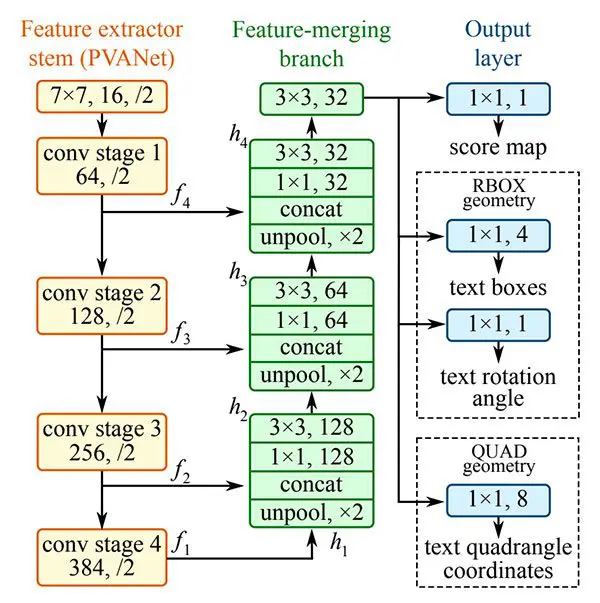

refer to 
https://pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/ for more details. 


In [19]:
%%capture
!pip install imutils

[INFO] loading EAST text detector...
[INFO] text detection took 0.288459 seconds


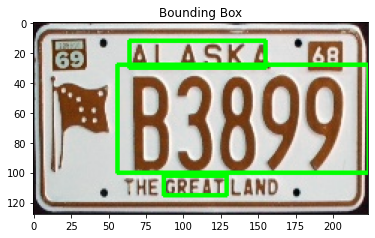

In [21]:
# import the necessary packages
import numpy as np
import time
from imutils.object_detection import non_max_suppression

min_confidence = 0.8
model = "/kaggle/input/frozen-east-text-detection/frozen_east_text_detection.pb"

# load the input image and grab the image dimensions
# image = cv2.imread(args["image"])
orig = image.copy()
(H, W) = image.shape[:2]
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (320, 320) 
rW = W / float(newW)
rH = H / float(newH)
# resize the image and grab the new image dimensions
image_res = cv2.resize(image, (newW, newH))
(H, W) = image_res.shape[:2]

# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(model)
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image_res, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]
	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < min_confidence:
			continue
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
# boxes = np.array(rects)
# remove the bounding boxes that are too narrow or too short
boxes = [box for box in boxes if (box[2]-box[0]) > 50]

# make sure the largetest bounding box is fully expended horizontally
boxes = sorted(boxes, key=lambda box: (box[2]-box[0])*(box[3]-box[1]))
startX, startY, endX, endY = boxes[-1]
startX = 0 if startX > W/4 else startX
endX = W if endX < 3*W/4 else endX
boxes[-1] = (startX, startY, W, endY)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
	# draw the bounding box on the image
	cntImage = cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
 
show_image(cntImage, 'Bounding Box')

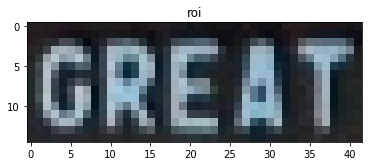

GREAT

[INFO] text detection took 0.175987 seconds


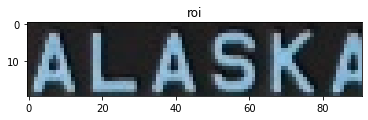

ALASK&¢

[INFO] text detection took 0.179211 seconds


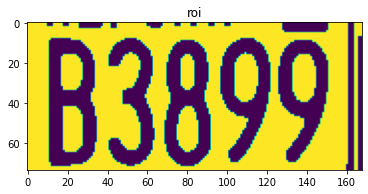

B3899|

[INFO] text detection took 0.177124 seconds


In [25]:
import time
# extract the text from boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    sx = int(startX * rW)
    sy = int(startY * rH)
    ex = int(endX * rW)
    ey = int((endY+5) * rH)
    # extract the region of interest
    roi = image[sy:ey, sx:ex]
    roi = blur_thresh(roi) if endY - startY > 50 else roi
    roi = denoise(roi) if endY - startY > 50 else roi
    roi = 255 - roi 
    plt.imshow(roi)
    plt.title('roi')
    plt.show()
    # configuration setting to convert image to string.
    config = ('-l eng --psm 6') # eng is English, psm 6 is for a single uniform block of text
    # now feeding image to tesseract
    start = time.time()
    det = pytesseract.image_to_string(roi, config=config)
    end = time.time()
    print(det)
    print("[INFO] text detection took {:.6f} seconds".format(end - start))

In [1]:
import gc
gc.collect()

0

## Easy OKR
EasyOCR consists of three components, The three main components of EasyOCR, are feature extraction, sequence labeling, and decoding.
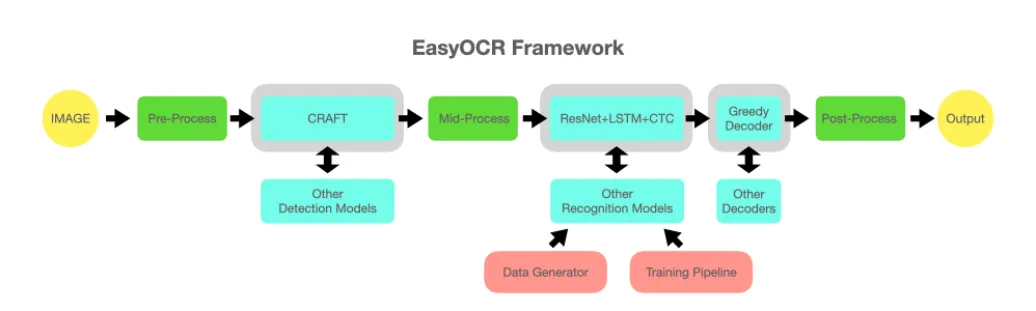
* feature extraction: deep learning models such as ResNet and VGG are used to create a set of features that can be utilized for additional analysis.
* sequence labeling: Long Short-Term Memory (LSTM) networks are uesed to interpret the extracted features’ sequential context.
* decoding: decodes and transcribes the labeled sequences into the actual recognized text using the Connectionist Temporal Classification (CTC) algorithm. 

please refer to [easy ocr comprehensive guide](https://medium.com/@adityamahajan.work/easyocr-a-comprehensive-guide-5ff1cb850168) for details.

In [26]:
%%capture
!pip install easyocr

[INFO] text detection took 0.042497 seconds
ALASKA
68
B3899 
THE GREAT Land


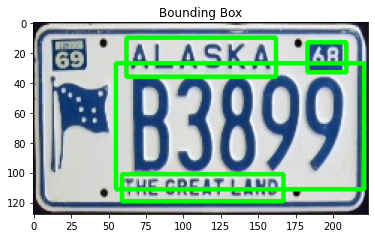

In [29]:
import easyocr
import cv2
import time
import matplotlib.pyplot as plt

path = "../input/us-license-plates-image-classification/new plates/test/ALASKA/1.jpg"
image = cv2.imread(path)
reader = easyocr.Reader(['en'])
start = time.time()
results = reader.readtext(image)
end = time.time()

# show timing information on text detection and recognition
print("[INFO] text detection took {:.6f} seconds".format(end - start))

for result in results:
    print(result[1])

for (bbox, text, prob) in results:
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    br = (int(br[0]), int(br[1]))
    cv2.rectangle(image, tl, br, (0, 255, 0), 2)
show_image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'Bounding Box')

Better than tesseract, easy OCR doens't need extra preprocessing on the image and is able to catch more price bounding box and get more accurate result with even less time!

## Keras OCR


In [2]:
%%capture
!pip install keras-ocr

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
[INFO] text prediction took 2.053978 seconds


AttributeError: 'str' object has no attribute 'copy'

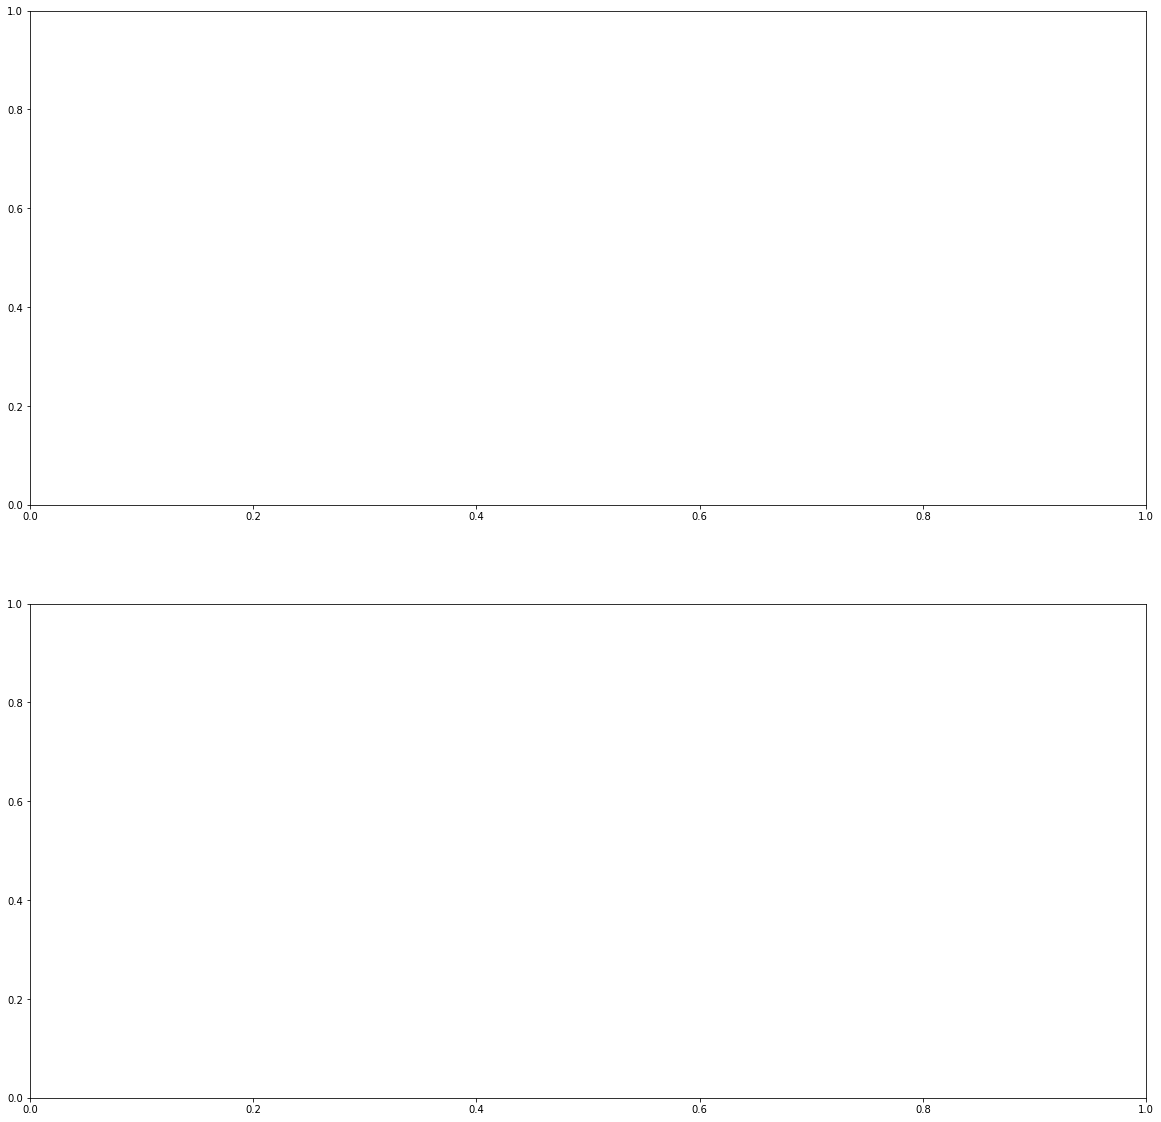

In [10]:
import matplotlib.pyplot as plt
import keras_ocr
import time
# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

# Get a set of three example images
images = [
    "/kaggle/input/us-license-plates-image-classification/new plates/test/ALABAMA/1.jpg",
    "/kaggle/input/us-license-plates-image-classification/new plates/test/ALASKA/1.jpg",
#     "/kaggle/input/us-license-plates-image-classification/new plates/test/AMERICAN SAMOA/1.jpg"
]

# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
start = time.time()
prediction_groups = pipeline.recognize(images)
end = time.time()

# show timing information on text detection and recognition
print("[INFO] text prediction took {:.6f} seconds".format(end - start))


# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

In [3]:
import os
import keras_ocr
benchmarking_dir = './benchmarking'
os.makedirs(benchmarking_dir, exist_ok=True)
dataset, (labels, images_dir) = keras_ocr.datasets.get_cocotext_recognizer_dataset(
    split='val',
    cache_dir='.',
    limit=1000,
    return_raw_labels=True,
    legible_only=False,
    english_only=False
)
val_ids = list(labels['imgs'])
val_filenames = [labels['imgs'][cocoid]['file_name'] for cocoid in val_ids]

Looking for ./coco-text/cocotext.v2.zip


In [8]:
#import zipfile
#import concurrent
#import json
#import io
#import base64
#import string

#import numpy as np
#import imgaug
#import matplotlib.pyplot as plt
import tqdm
import keras_ocr
step_size = 100
pipeline = keras_ocr.pipeline.Pipeline(scale=2)
for scale in [3]:
    pipeline.scale = scale
    keras_ocr_annotations = {}
    for step in tqdm.tqdm(range(0, len(val_filenames), step_size)):
        current_filenames = val_filenames[step:step+step_size]
        prediction_groups = pipeline.recognize([
          os.path.join(images_dir, filename) for filename in current_filenames
        ])
        for filename, predictions in zip(current_filenames, prediction_groups):
            keras_ocr_annotations[filename] = [
                {
                    'text': text, 'vertices': box.tolist()
                } for text, box in predictions
            ]
    with open(os.path.join(benchmarking_dir, f'keras_ocr_annotations_scale_{scale}.json'), 'w') as f:
        f.write(json.dumps(keras_ocr_annotations))

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


NameError: name 'val_filenames' is not defined

# Analyze all images in test folder

In [6]:
image_map = {}
# read subdirectory under test folder and save to a map
import os
for root, dirs, files in os.walk("test"):
    image_map[root] = files
    print(root)
    print(dirs)
    print(files)
    print("===========")

With use of tesseract, we will extract the text from the mage.


# Compare the performance between above main stream OCR framework

# 